## Context: Test Run Ahead of the Real Migration

This is a **test analysis** to understand the impact of switching SQL tracking methods, ahead of the actual data pipeline migration. The goal is to surface any product-level differences now so we’re prepared when the new logic goes live.

## Why We’re Changing the SQL Logic

Until now, our SQL reporting relied on a static `sql_date` field in Salesforce, set up ages ago by the CS team. It was meant to reflect when a lead became SQL, but we discovered several inconsistencies (e.g. leads having a `sql_date` even though they were never marked as SQL).

We tried investigating, but the logic is buried in Salesforce and no one, including the CS team, has a clear view into how it works anymore. So we’re moving to something cleaner and more accurate.

The new method uses the `salesforce_leadhistory` table to find the **first time a lead’s status changed to SQL**. It’s timestamped, auditable, and reflects what actually happened.

Below is the overall discrepancies analysis on the 2024 legacy data.

In [2]:
# --- Setup ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("sqls_raw_combined.csv", parse_dates=['record_date'])

# Preprocess
df['quarter'] = df['record_date'].dt.to_period('Q')
df['year'] = df['record_date'].dt.year
df_2024 = df[df['year'] == 2024]

/tmp/ipykernel_105927/1137319166.py:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['quarter'] = df['record_date'].dt.to_period('Q')


1. Total SQL Count for 2024 by Method

In [17]:
total_counts = df_2024.groupby('source').size().reset_index(name='sql_count')
total_counts.style.hide(axis="index")

source,sql_count
legacy,3778
new,3782


2. Total SQL Count for 2024 by Product and Method

In [5]:
product_counts = df_2024.groupby(['product', 'source']).size().unstack(fill_value=0)
product_counts['difference'] = product_counts['new'] - product_counts['legacy']
product_counts = product_counts.sort_values(by='difference', ascending=False)
product_counts

source,legacy,new,difference
product,,,
Telco/Networking,361,364,3
Openstack,536,538,2
Pro Security,949,951,2
K8s,183,184,1
Server,108,109,1
Kubeflow/ ai,423,424,1
AI (x-portfolio),17,17,0
Pro WSL,2,2,0
MicroCloud,79,79,0


3. Heatmap of % Differences by Quarter & Product

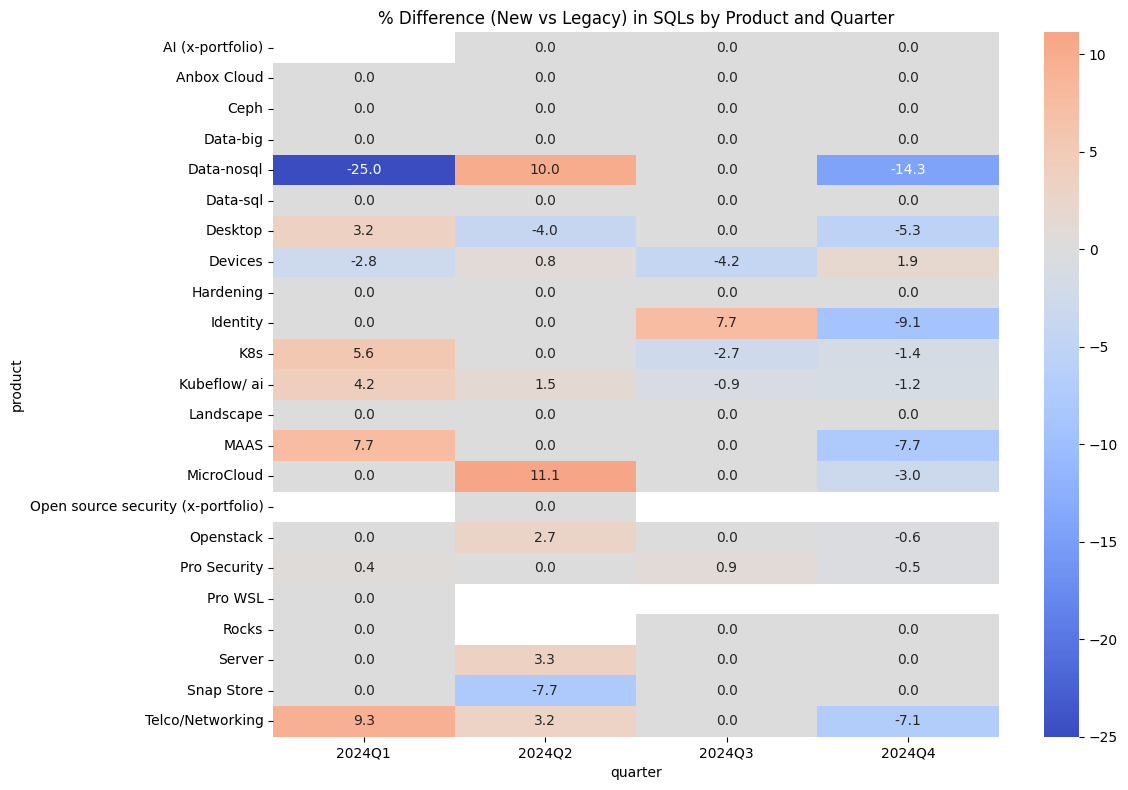

In [15]:
quarterly_diff = df_2024.groupby(['quarter', 'product', 'source']).size().unstack(fill_value=0).reset_index()
quarterly_diff['difference'] = quarterly_diff['new'] - quarterly_diff['legacy']
quarterly_diff['abs_difference'] = quarterly_diff['difference'].abs()

# Sort by absolute difference
quarterly_diff = quarterly_diff.sort_values(by='abs_difference', ascending=False)

quarterly_diff['percent_diff'] = 100 * (quarterly_diff['new'] - quarterly_diff['legacy']) / quarterly_diff['legacy'].replace(0, pd.NA)
heatmap_data = quarterly_diff.pivot(index='product', columns='quarter', values='percent_diff')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="coolwarm", center=0)
plt.title('% Difference (New vs Legacy) in SQLs by Product and Quarter')
plt.tight_layout()
plt.show()

4. Line Plots for Products with Differences

=== Products with Net and Percent SQL Differences ===


product,net_difference,percent_difference,num_quarters_with_difference,quarters_with_difference
Telco/Networking,3,1.100000,3,"2024Q1, 2024Q2, 2024Q4"
Openstack,2,0.700000,2,"2024Q2, 2024Q4"
Pro Security,2,0.300000,3,"2024Q1, 2024Q3, 2024Q4"
Kubeflow/ ai,1,0.200000,4,"2024Q1, 2024Q2, 2024Q3, 2024Q4"
K8s,1,0.600000,3,"2024Q1, 2024Q3, 2024Q4"
Server,1,3.300000,1,2024Q2
MAAS,0,0.000000,2,"2024Q1, 2024Q4"
MicroCloud,0,0.000000,2,"2024Q2, 2024Q4"
Identity,0,0.000000,2,"2024Q3, 2024Q4"
Data-nosql,-1,-4.800000,3,"2024Q1, 2024Q2, 2024Q4"


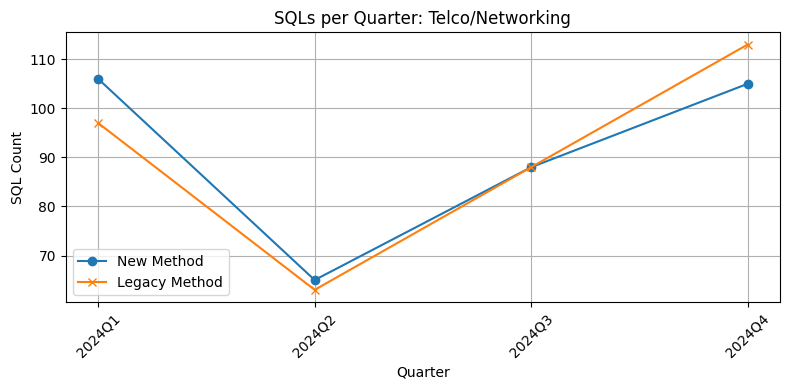

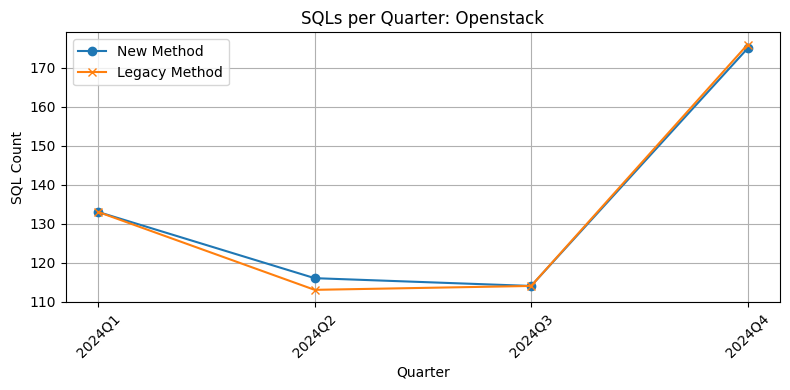

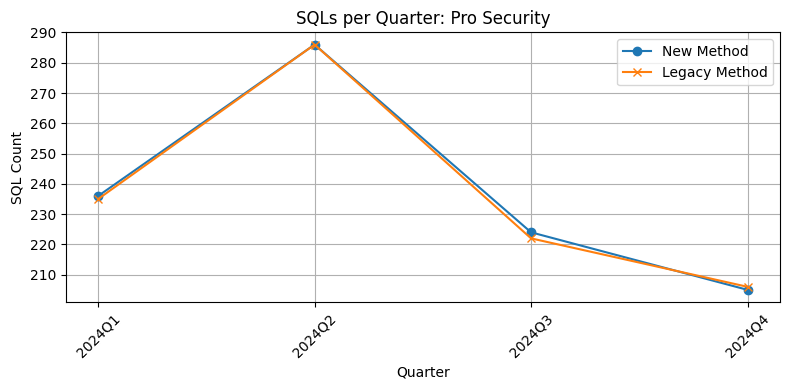

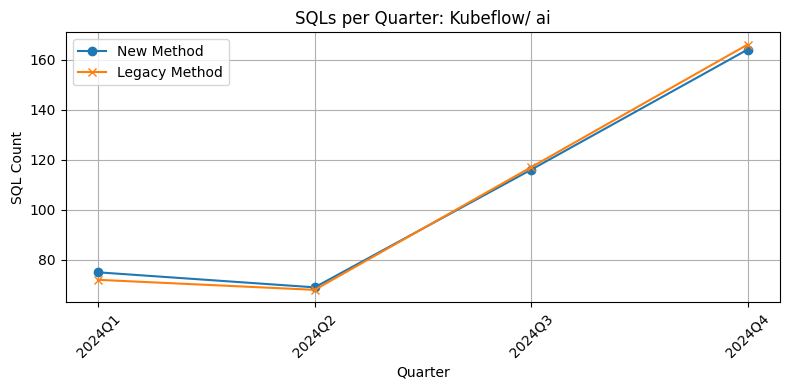

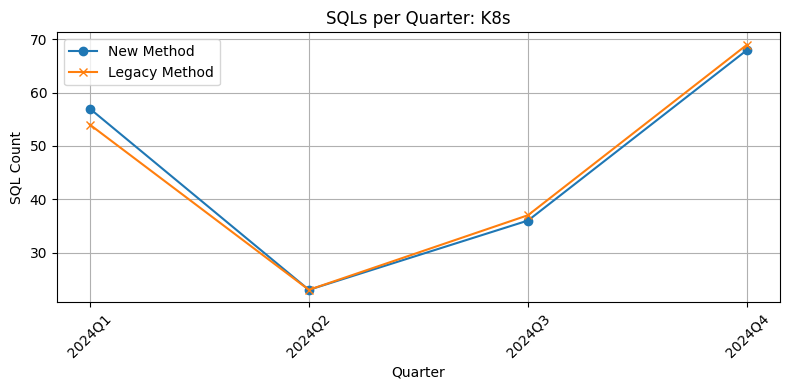

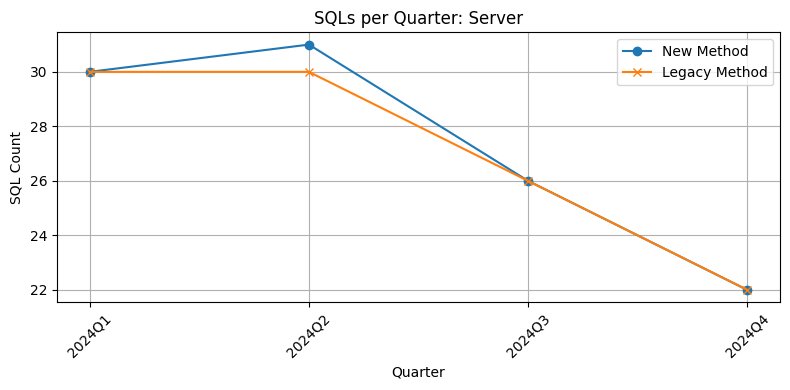

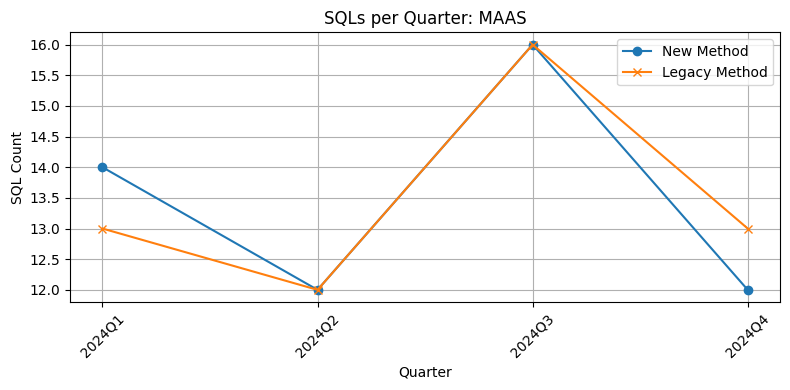

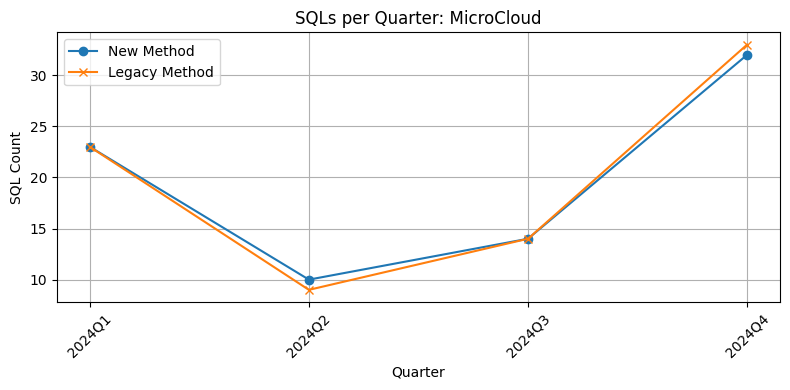

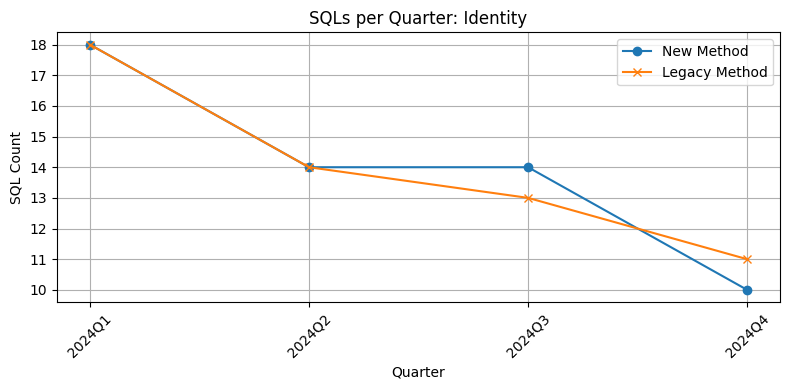

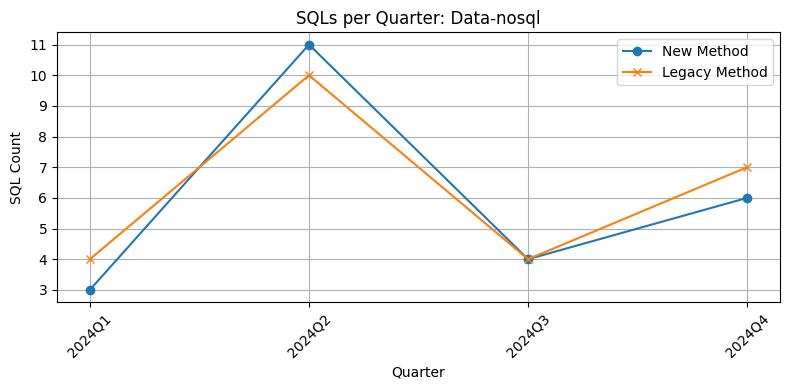

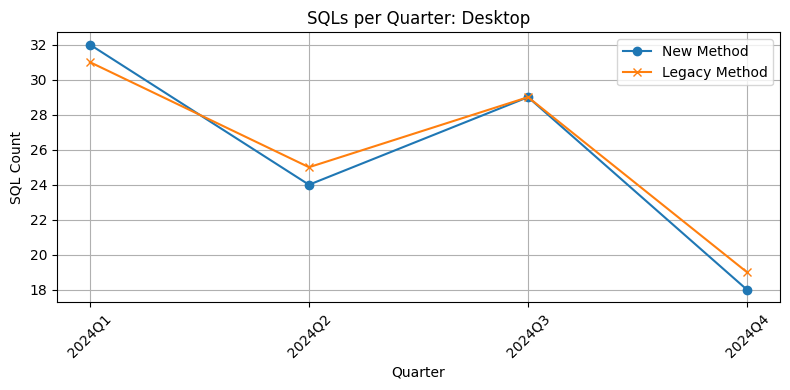

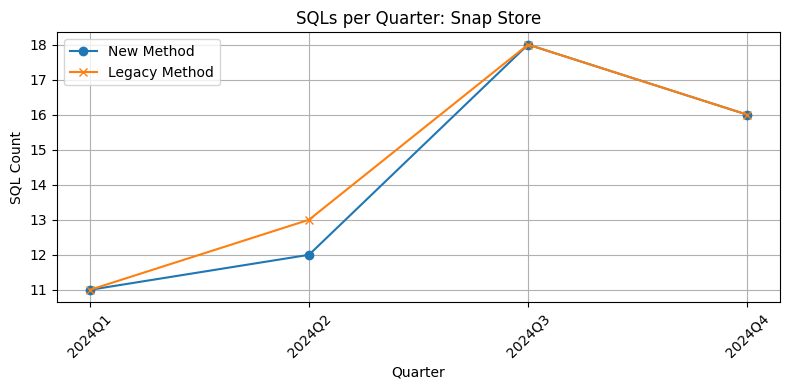

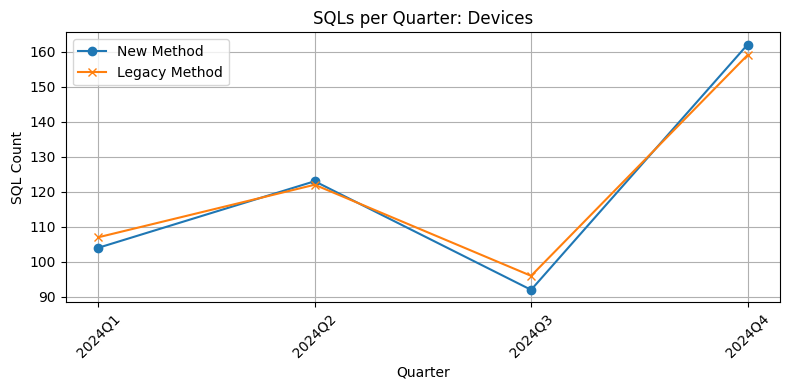

In [16]:
# 1. Aggregate quarterly counts
quarterly = df_2024.groupby(['quarter', 'product', 'source']).size().reset_index(name='sql_count')

# 2. Pivot to compare methods side by side
pivot = quarterly.pivot(index=['quarter', 'product'], columns='source', values='sql_count').fillna(0).reset_index()

# 3. Calculate net difference
pivot['net_difference'] = pivot['new'] - pivot['legacy']

# 4. Filter only rows with non-zero net difference
diff_rows = pivot[pivot['net_difference'] != 0]

# 5. Summarize per product
summary_table = (
    diff_rows.groupby('product')
    .agg(
        quarters_with_difference=('quarter', lambda q: ', '.join(sorted(str(x) for x in q.unique()))),
        num_quarters_with_difference=('quarter', 'nunique'),
        net_difference=('net_difference', 'sum'),
        legacy_total=('legacy', 'sum')  # Needed for percentage
    )
    .reset_index()
)

# 6. Calculate percentage difference (handle divide-by-zero)
summary_table['percent_difference'] = summary_table.apply(
    lambda row: round(100 * row['net_difference'] / row['legacy_total'], 1) if row['legacy_total'] != 0 else None,
    axis=1
)

# 7. Sort by net difference
summary_table = summary_table.sort_values(by='net_difference', ascending=False)

# Display table
print("=== Products with Net and Percent SQL Differences ===")
display(
summary_table[['product', 'net_difference', 'percent_difference',
               'num_quarters_with_difference', 'quarters_with_difference']].style.hide(axis="index")
)

# 8. Plot line charts per product with differences
products_with_diff = summary_table['product'].tolist()

for product in products_with_diff:
    product_data = pivot[pivot['product'] == product].sort_values('quarter')

    plt.figure(figsize=(8, 4))
    plt.plot(product_data['quarter'].astype(str), product_data['new'], label='New Method', marker='o')
    plt.plot(product_data['quarter'].astype(str), product_data['legacy'], label='Legacy Method', marker='x')

    plt.title(f'SQLs per Quarter: {product}')
    plt.xlabel('Quarter')
    plt.ylabel('SQL Count')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


4. Generate summary into CSV

In [20]:
# 1. Start from the pivoted quarterly data (already has legacy and new side-by-side)
quarter_summary = pivot.copy()

# 2. Calculate net and % difference
quarter_summary['net_difference'] = quarter_summary['new'] - quarter_summary['legacy']
quarter_summary['percent_difference'] = quarter_summary.apply(
    lambda row: round(100 * row['net_difference'] / row['legacy'], 1) if row['legacy'] != 0 else None,
    axis=1
)

# 3. Reorder and rename columns
quarter_summary = quarter_summary[[
    'quarter', 'product', 'legacy', 'new', 'net_difference', 'percent_difference'
]]
quarter_summary.columns = ['quarter', 'product', 'legacy_count', 'new_count', 'net_difference', 'net_difference_percent']

# 4. Save to CSV
quarter_summary.to_csv('sql_quarterly_product_comparison.csv', index=False)

# 5. Display the first few rows to confirm
quarter_summary.head().style.hide(axis='index')


quarter,product,legacy_count,new_count,net_difference,net_difference_percent
2024Q1,Anbox Cloud,1,1,0,0.000000
2024Q1,Ceph,17,17,0,0.000000
2024Q1,Data-big,3,3,0,0.000000
2024Q1,Data-nosql,4,3,-1,-25.000000
2024Q1,Data-sql,3,3,0,0.000000


## Analysis summary

Overall SQL counts between the two methods are very similar, which is great—it means we’re not disrupting big-picture metrics. But at the **product and quarter level**, a few differences stand out.

## Products with the Biggest Net Changes

- **Telco/Networking**, **Openstack**, and **Pro Security** each gained around **+2 to +3 SQLs**, likely leads that were missed in the old logic.
- **Devices** showed a **net drop of 3 SQLs**, making it the most negatively affected product.

## Products That Fluctuate the Most

- **Telco/Networking** had the biggest quarter-to-quarter swings, even though its total change was small.
- **Devices**, **Kubeflow/AI**, and **K8s** also had inconsistent results across quarters, which could affect quarter-based reporting.

## Products That Didn’t Budge

Most products—including **MAAS**, **MicroCloud**, **Ceph**, and **Hardening**—had **no changes at all** across any quarter, showing strong alignment between the old and new tracking methods.

## Note on Upcoming Changes

When the product mapping pipeline is migrated to **dbt**, we’ll also switch from using **email address** to **Salesforce lead ID** as the primary identifier. This will resolve some edge cases, like duplicate records across objects or updated emails.

I don’t expect major changes from this—probably **no more than 1–2%** across the full pipeline—but it’s worth flagging ahead of time.